In [0]:
# importing necessary libraries
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns

This is a rough implementation of Faster RCNN paper.It will helps you to undertstand concepts better.We will divide the section to 3 parts:



1.   Region Proposal Network
2.   Preprocessing of ROI by RPN
3.   Fast RCNN



The data flow will be as follows:

1. Feature extraction of image
2. creating anchor targets(used while calculating loss)
3. Location of object score predictions of RPN network
4. Taking top N locations by some preprocessing and NMS
5. generating proposal targets for each location suggested in 4.(used while calculating loss.ie after prediction)
6. Passing these top N locations through Fast R-CNN network and generating locations and cls predictions for each locations.
7. Using 2 and 3 to calculate rpn_cls_loss and rpn_reg_loss.
8. using 5 and 6 to calculate roi_cls_loss and roi_reg_loss.

---



---



Defining the input image and bounding boxes and their labels

In [0]:
#input image attributes

image = torch.zeros((1, 3, 800, 800)).float()
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]]) # [y1, x1, y2, x2] format
box_classes = torch.LongTensor([6, 8]) # 0 represents background
sampling_ratio = 16

We will start by designing Region Proposal network and extend the concept to Fast RCNN

# **1. Region Proposal Network**

# **1.1 Feature extraction block**

VGG16 act as a feature extraction module.This act as a backbone for RPN as well as Fast RCNN.We have to make few changes to VGG16 to make it work.The input of nwk is 800.So we need to find feature map where the size become 800//16 and trim there.

1. create a dummy image of same size that of input

In [3]:
sample_img = torch.zeros((1,3,800,800)).float()
print(sample_img.shape)

torch.Size([1, 3, 800, 800])


2. Pass the image through the VGG layers and subset the list when outputsize of image is below required level (800//16). Also convert this list to Sequential module

In [4]:
model = torchvision.models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# our feature map size is 800//16 = 50 so we need to append features till the image size becomes so for feature extraction block
img  = sample_img.clone()
features = []
for f in model.features:
    img = f(img)
    if img.shape[2] < 800//16:
        break
    features.append(f)

feature_extractor = nn.Sequential(*features)
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

3. Now get the feature map when the image is passed through the features we selected

In [6]:
out_map = feature_extractor(image)
print(out_map.shape)

torch.Size([1, 512, 50, 50])


# **1.2 Designing Anchor boxes**

We will divide this into three steps:
* First we  will generate Anchor boxes at all the feature map location.
* Then we will assign the labels 

* Then we will assign location of objects (with respect to the anchor) to each and every anchor.

Note: We will use anchor_scales of 8, 16, 32, ratio of 0.5, 1, 2 and sub sampling of 16 (Since we have pooled our image from 800 px to 50px). Now every pixel in the output feature map maps to corresponding 16 * 16 pixels in the image

## Anchor box creation

At each pixel location on the feature map, We need to generate 9 anchor boxes (number of anchor_scales and number of ratios) and each anchor box will have ‘y1’, ‘x1’, ‘y2’, ‘x2’. So at each location anchor will have a shape of (9, 4)

In [0]:
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]
feat_size = (800//16)  #50

First we will design centres for the anchor boxes

In [8]:
center_x = np.arange(16, (feat_size+1) * 16, 16)  # 50 values
center_y = np.arange(16, (feat_size+1) * 16, 16)

centers = np.zeros((len(center_x) * len(center_x), 2))   #2500 x 2



index = 0
for x in range(len(center_x)):
    for y in range(len(center_y)):
        centers[index, 0] = center_y[y] - 8
        centers[index, 1] = center_x[x] - 8
        index += 1

print(centers.shape)
centers


### More optimal way of doing the code ### 
# center_y = np.tile(center_y,50)
# center_x = np.repeat(center_x,50)
# centers[0:,0] = center_y - 8
# centers[0:,1] = center_x - 8


(2500, 2)


array([[  8.,   8.],
       [ 24.,   8.],
       [ 40.,   8.],
       ...,
       [760., 792.],
       [776., 792.],
       [792., 792.]])

Now for each of these centre points we will find coordinates(y1,x1,y2,x2) of 9 anchor boxes

In [9]:
# designing anchor boxes with different scales and ratios
anchors = np.zeros((len(centers) * 9, 4), dtype=np.float32)

index = 0
for c in centers:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = sampling_ratio * anchor_scales[j] * np.sqrt(ratios[i])
            w = sampling_ratio * anchor_scales[j] * np.sqrt(1. / ratios[i])

            # getting coordinates
            anchors[index, 0] = ctr_y - h / 2.
            anchors[index, 1] = ctr_x - w / 2.
            anchors[index, 2] = ctr_y + h / 2.
            anchors[index, 3] = ctr_x + w / 2.
            index += 1

print(anchors.shape)
print(anchors)


### More optimal way of doing the code ### 
# anchors = np.zeros((len(centers) * 9, 4), dtype=np.float32)
# centers_  = np.repeat(centers,9,axis=0)
# mesh = np.array(np.meshgrid(np.array(anchor_scales),np.array(ratios)))
# combinations = mesh.T.reshape(-1, 2)
# combinations = np.tile(combinations,(centers.shape[0],1))
# h = sampling_ratio * combinations[:,0] * np.sqrt(combinations[:,1])
# w = sampling_ratio * combinations[:,0] * np.sqrt(1. / combinations[:,1])
# # getting coordinates
# anchors[:, 0] = centers_[:,0] - h / 2.
# anchors[:, 1] = centers_[:,1] - w / 2.
# anchors[:, 2] = centers_[:,0] + h / 2.
# anchors[:, 3] = centers_[:,1] + w / 2.

# print(anchors.shape)
# anchors

(22500, 4)
[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 ...
 [ 701.49036   746.7452    882.50964   837.2548  ]
 [ 610.98065   701.49036   973.01935   882.50964 ]
 [ 429.96133   610.98065  1154.0387    973.01935 ]]


## Assigning labels to these anchor boxes

We assign labels in such a way that:<br>
<p>

<br>

* positive label(1) for all anchor boxes which has maximum iou with ground truth box. Also we will assign positive label for those anchor boxes whose iou >= 0.7 with ground truth box.It indicates region containing object<br>

* zero label(0) for all those anchor boxes with iou < 0.3 with ground truth box.It indicates region that doesnot contain object<br>

* negative (-1) label for others which we will ignore later at the time of training


<br>

We will also do a positive as well as negative sampling as mentioned in paper
<p>
The Faster_R-CNN paper phrases as follows Each mini-batch arises from a single image that contains many positive and negitive example anchors, but this will bias towards negitive samples as they are dominate. Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones.. From this we can derive two variable as follows

1. Initially we assign -1 label for all anchor boxes

In [10]:
labels = np.empty(len(anchors))
labels.fill(-1)
labels


array([-1., -1., -1., ..., -1., -1., -1.])

2. Filter anchor boxes with y1,x1,y2 and x2 coords between 0 and 800.We neglet all other anchor boxes

In [11]:
inside_indexes = np.where(
    (anchors[:, 0] >= 0) &
    (anchors[:, 1] >= 0) &
    (anchors[:, 2] <= 800) &
    (anchors[:, 3] <= 800)
)[0]


valid_labels = labels[inside_indexes]

# only get the valid anchor boxes
valid_anchor_boxes = anchors[inside_indexes]
print(valid_anchor_boxes.shape)

(8940, 4)


3. calculate iou of anchor boxes with ground truth boxes

In [12]:
def get_ious(anchors,bbox):
    bboxes = bbox.clone().numpy()
    ious = np.zeros((len(anchors),len(bboxes)))
    for num1,i in enumerate(anchors):
        ya1,xa1,ya2,xa2 = i  
        anchor_area = (ya2-ya1) * (xa2-xa1)
        for num2,j in enumerate(bboxes):
            yb1,xb1,yb2,xb2 = j
            bbox_area = (yb2-yb1) * (xb2-xb1)
            top_y = max(ya1,yb1)
            top_x = max(xa1,xb1)
            bottom_y = min(ya2,yb2)
            bottom_x = min(xa2,xb2)

            if (top_x < bottom_x) and (top_y < bottom_y):
                intersection_area = (bottom_x - top_x) * (bottom_y - top_y)
                iou =  intersection_area/(anchor_area + bbox_area - intersection_area)
            else:
                iou = 0
            ious[num1,num2] = iou
    return ious


ious = get_ious(valid_anchor_boxes,bbox)
print(ious.shape)
ious

(8940, 2)


array([[0.06811669, 0.        ],
       [0.07083762, 0.        ],
       [0.07083762, 0.        ],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

4. Now we will do labeling based on iou.For that we need to find the following: <br>
case1: the anchor boxes that share maximum iou with ground truth box<br>
case2: ground truth boxes that share maximum iou with each anchor box

case 1:

In [13]:
# first find the anchor boxes which has max iou with ground truth boxes
case1_idx = np.argmax(ious,axis=0)
print(case1_idx)

#listing all anchor boxes with those iou
case1_iou = ious[case1_idx,np.arange(ious.shape[1])]
print(case1_iou)
case1_indexes = np.where(ious == case1_iou)[0]
print(case1_indexes) 

[2262 5620]
[0.68130493 0.61035156]
[2262 2508 5620 5628 5636 5644 5866 5874 5882 5890 6112 6120 6128 6136
 6358 6366 6374 6382]


case 2:

In [14]:
# find the bbox that share maxium iou with anchor box
case2_idx = np.argmax(ious,axis=1)
print(case2_idx)
# Now find their ious
case2_iou = ious[np.arange(ious.shape[0]),case2_idx]
print(case2_iou)

[0 0 0 ... 0 0 0]
[0.06811669 0.07083762 0.07083762 ... 0.         0.         0.        ]


In [0]:
# labeling
positive_threshold = 0.7
negative_threshold = 0.3

valid_labels[case2_iou >= positive_threshold] = 1
valid_labels[case2_iou < negative_threshold] = 0
valid_labels[case1_indexes] = 1

In [16]:
print(valid_labels.shape)
valid_labels

(8940,)


array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
# helper function for plotting
def label_plot(valid_labels):
  pos = np.sum(valid_labels == 1) + np.sum(valid_labels == 8) + np.sum(valid_labels == 6)
  neg = np.sum(valid_labels == 0)
  ignore = np.sum(valid_labels == -1)
  total = len(valid_labels)
  
  print(f'Out of total  {len(valid_labels)} labels, there are {pos} positive label , {neg} negative labels and {ignore} ignore labels')
  sns.countplot(valid_labels)
  plt.show

Out of total  8940 labels, there are 18 positive label , 7690 negative labels and 1232 ignore labels


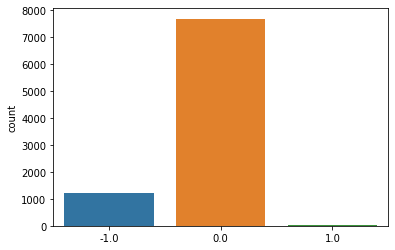

In [18]:
label_plot(valid_labels)

Now we will do the minibatch sampling that we described earlier.ie,Normally in an image negative class dominates the positive class.We have to make them in ratio 1:1.
* Normally we need 128 positive samples and 128 negative samples.<br>
* If there are fewer than 128 positive samples in an image, we pad that mini-batch with negitive ones<br>
* If there are more positive samples we will disble(-1) those extra samples.similarly for negative samples

In [0]:
pos_ratio = 0.5
n_sample = 256
# total positive samples
n_pos = pos_ratio * n_sample


#labeling positive samples
pos_idxes = np.where(valid_labels == 1)[0]
pos_labels_in_image = len(pos_idxes)

# uf positive samples > 128
if pos_labels_in_image > n_pos:
  # disable the later samples
  disable_index = np.random.choice(pos_idxes, size = (n_pos - pos_labels_in_image), replace = False)
  valid_labels[disable_index] = -1 


#labeling negative samples
neg_idxes = np.where(valid_labels == 0)[0]
neg_labels_in_image = len(neg_idxes)
req_neg_labels = n_sample - pos_labels_in_image

if neg_labels_in_image > req_neg_labels:
  # sample a small array
  disable_index = np.random.choice(neg_idxes, size = (neg_labels_in_image - req_neg_labels), replace = False)
  valid_labels[disable_index] = -1 

Out of total  8940 labels, there are 18 positive label , 238 negative labels and 8684 ignore labels


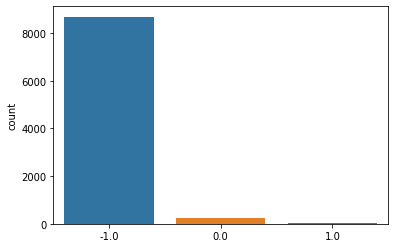

In [20]:
label_plot(valid_labels)

Now we will assign these labels to all anchor boxes we have

Out of total  22500 labels, there are 18 positive label , 238 negative labels and 22244 ignore labels


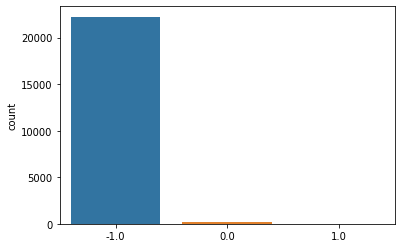

In [21]:
#matching labels
labels[inside_indexes] = valid_labels

label_plot(labels)

## Assigning bbox coordinates for anchor boxes

Now lets assign the locations to each anchor box with the ground truth object which has maximum iou. Note, we will assign anchor locs to all the valid anchor boxes irrespective of its label, later when we are calculating the losses, we can remove them with simple filters.

We already know which ground truth object has high iou with each anchor box, Now we need to find the locations of ground truth with respect to the anchor box location. Faster_R-CNN uses the following parametrizion for this

**t_{x} = (x - x_{a})/w_{a}<br>**
**t_{y} = (y - y_{a})/h_{a}<br>**
**t_{w} = log(w/ w_a)<br>**
**t_{h} = log(h/ h_a)<br>**

x, y , w, h are the groud truth box center co-ordinates, width and height. x_a, y_a, h_a and w_a and anchor boxes center cooridinates, width and height.



In [22]:
# For each anchor box find the groundtruth which share maximum iou
max_iou_bbox = bbox[case2_idx]
max_iou_bbox

tensor([[ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.],
        ...,
        [ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.]])

In [23]:
#do a tranfromation to these boxes
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = (max_iou_bbox[:, 2] - max_iou_bbox[:, 0]).cpu().numpy()
base_width = (max_iou_bbox[:, 3] - max_iou_bbox[:, 1]).cpu().numpy()
base_ctr_y = max_iou_bbox[:, 0].cpu().numpy() + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1].cpu().numpy() + 0.5 * base_width



# we will set a minimum eps value for height and width as we divide wih them
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)
anchor_locs

(8940, 4)


array([[ 0.5855727 ,  2.3091455 ,  0.7415673 ,  1.647276  ],
       [ 0.49718437,  2.3091455 ,  0.7415673 ,  1.647276  ],
       [ 0.40879607,  2.3091455 ,  0.7415673 ,  1.647276  ],
       ...,
       [-2.50802   , -5.292254  ,  0.7415677 ,  1.6472763 ],
       [-2.5964084 , -5.292254  ,  0.7415677 ,  1.6472763 ],
       [-2.6847968 , -5.292254  ,  0.7415677 ,  1.6472763 ]],
      dtype=float32)

In [24]:
anchor_locations = np.zeros((len(anchors),4),dtype=anchor_locs.dtype)
anchor_locations[inside_indexes] = anchor_locs
print(anchor_locations.shape)
anchor_locations

(22500, 4)


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

## **1.3 Designing remaining layers (ROI prediction)**


To generate region proposals we slides a nxn sliding window over the feature map we generated earlier.Now we take the output of this sliding window and convert to 512 dimensional vector. This feature is fed into two sibling fully connected layers

* A box regrression layer
* A box classification layer

we use n=3, as noted in Faster_R-CNN paper. We can implement this Architecture using n x n convolutional layer followed by two sibiling 1 x 1 convolutional layers


In [25]:
input_channels = 512 #512 in case of VGG16  
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(input_channels,mid_channels,3 , 1, 1)
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)


# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
# Now we will pass the output that we got from feature extractor
x = conv1(out_map)  # out_map is obtained in section 1
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


In [27]:
# Now we will reassign this to get required shape

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores_ = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores_.shape)

# probaility of anchorboxes containing object
objectness_score = pred_cls_scores_.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)


# probaility of anchorboxes containing object and probaility of anchorboxes does not containing object
pred_cls_scores = pred_cls_scores_.view(1, -1, 2)
print(pred_cls_scores.shape)


torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


pred_cls_scores and pred_anchor_locs are the output the RPN network and the losses to updates the weights
pred_cls_scores and objectness_scores are used as inputs to the proposal layer, which generate a set of proposal which are further used by RoI network. We will see this in the next section

<br>



---



---







<br>

# **2. Preprocessing ROI proposals to select top N proposals**

## **2.1 Reduce ROI proposals by Non Max Suppression**






The Faster R_CNN says, RPN proposals highly overlap with each other. To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores. We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image. After an ablation study, the authors show that NMS does not harm the ultimate detection accuracy, but substantially reduces the number of proposals. After NMS, we use the top-N ranked proposal regions for detection. In the following we training Fast R-CNN using 2000 RPN proposals. During testing they evaluate only 300 proposals, they have tested this with various numbers and obtained this.

Parameters:

* nms_thresh - threshold of suppression
* n_train_pre_nms — number of bboxes before nms during training
* n_train_post_nms — number of bboxes after nms during training
* n_test_pre_nms — number of bboxes before nms during testing
* n_test_post_nms — number of bboxes after nms during testing
* min_size — minimum height of the object required to create a proposal.

In [0]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

We need to do the following to generate ROI proposals to the nwk.

1. convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.<br>
2. clip the predicted boxes to the image<br>
3. Remove predicted boxes with either height or width < threshold (min_size).<br>
4. Sort all (proposal, score) pairs by score from highest to lowest.<br>
5. Take top pre_nms_topN (e.g. 12000 while training and 300 while testing).<br>
6. Apply nms threshold > 0.7<br>
7. Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)<br>

1. convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.<br>

Reverse of what we done earlier:


* x = (w_{a} * ctr_x_{p}) + ctr_x_{a}
* y = (h_{a} * ctr_x_{p}) + ctr_x_{a}
* h = np.exp(h_{p}) * h_{a}
* w = np.exp(w_{p}) * w_{a}

and later convert to y1, x1, y2, x2 format

In [29]:
# Convert anchors format from y1, x1, y2, x2 to ctr_x, ctr_y, h, w

anc_height = anchors[:, 2] - anchors[:, 0]  #y2 - y1
anc_width = anchors[:, 3] - anchors[:, 1]  # x2 - x1
anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
anc_ctr_x = anchors[:, 1] + 0.5 * anc_width


pred_anchor_locs_numpy = pred_anchor_locs[0].data.numpy()
objectness_score_numpy = objectness_score[0].data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]

# use the above formulas
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]


#convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2] format
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w

roi

array([[ -38.5233  ,  -84.514915,   53.80548 ,   94.66781 ],
       [ -81.282295, -160.81387 ,   99.76351 ,  199.64944 ],
       [-185.6216  , -370.83905 ,  191.54951 ,  355.69855 ],
       ...,
       [ 699.64355 ,  745.03687 ,  881.33594 ,  836.7079  ],
       [ 618.0458  ,  698.9514  ,  976.3085  ,  879.38586 ],
       [ 433.74872 ,  616.964   , 1153.2109  ,  971.75    ]],
      dtype=float32)

2.clipping the boxes

In [30]:
# cliping the predicting boxes to image size
img_size = (800,800)
roi[:, 0:4:2] = np.clip(roi[:, 0:4:2], 0 ,img_size[0])
roi[:, 1:4:2] = np.clip(roi[:, 1:4:2], 0 ,img_size[1])
roi

array([[  0.     ,   0.     ,  53.80548,  94.66781],
       [  0.     ,   0.     ,  99.76351, 199.64944],
       [  0.     ,   0.     , 191.54951, 355.69855],
       ...,
       [699.64355, 745.03687, 800.     , 800.     ],
       [618.0458 , 698.9514 , 800.     , 800.     ],
       [433.74872, 616.964  , 800.     , 800.     ]], dtype=float32)

3. Remove predicted boxes with either height or width < threshold (ie.less than 16)

In [31]:
# removing boxes with height and width < threshold (16)
# %% remove small ones
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
scores = objectness_score_numpy[keep]
print(scores.shape)
print(roi.shape)

(22500,)
(22500, 4)


4. Sort all (proposal, score) pairs by score from highest to lowest.

In [32]:
ordered_scores = scores.ravel().argsort()[::-1]
print(ordered_scores)

[ 460  883  472 ... 1339  462    6]


5. Take top N boxes (pre_nms_top N) (e.g. 12000 while training and 300 while testing)

In [33]:
#indexes of top training anchorboxes 
ordered_scores = ordered_scores[:n_train_pre_nms]  #taking only first 12000 proposals
roi = roi[ordered_scores, :]
print(roi.shape)
print(roi)

(12000, 4)
[[  0.        0.      124.7566  214.72182]
 [689.08014   0.      800.      219.22293]
 [  0.        0.      166.14523 143.88687]
 ...
 [635.19714 201.05414 800.      291.9385 ]
 [635.19714 409.05417 800.      499.9385 ]
 [635.19714 281.05417 800.      371.9385 ]]


6. Apply non-maximum supression threshold > 0.7 . We keep the threshold at 0.7. threshold defines the minimum overlapping area required to merge/remove overlapping bounding boxes

In [0]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

areas = (x2 - x1 + 1) * (y2 - y1 + 1)
order = ordered_scores.argsort()[::-1]

keep = []

while len(order) > 1:
    i = order[0]
    keep.append(i)
    # finding coords of intersection rectangle
    top_x = np.maximum(x1[i], x1[order[1:]])
    top_y = np.maximum(y1[i], y1[order[1:]])
    bottom_x = np.minimum(x2[i], x2[order[1:]])
    bottom_y = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, bottom_x - top_x + 1)
    h = np.maximum(0.0, bottom_y - top_y + 1)

    intersection_area = w * h
    iou_ = intersection_area/(areas[i] + areas[order[1:]] - intersection_area)

    inds = np.where(iou_ <= nms_thresh)[0]  #all indexes which have iou <= 0.7 #remove all boxes above it
    order = order[inds + 1]

keep = keep[:n_train_post_nms]  # while training/testing , use accordingly
roi = roi[keep] 

In [35]:
roi.shape

(1968, 4)

The final region proposals were obtained, This is used as the input to ROI pooling

# **2.2 Assigning labels(classes) and bbox coordinates for FastRCNN proposals**

## Assigning Labels

We will create target from these proposals.

Parameters: 
* n_sample: Number of samples to sample from roi, The default value is 128.
* pos_ratio: the number of positive examples out of the n_samples. The default values is 0.25.
* pos_iou_thesh: The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
* [neg_iou_threshold_lo, neg_iou_threshold_hi] : [0.0, 0.5], The overlap value bounding required to consider a region proposal as negitive [background object].

In [0]:
n_samples = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

1. find the iou of roi's with all ground truth boxes



In [37]:
ious_ = get_ious(roi,bbox)
print(ious_.shape)
ious_

(1968, 2)


array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.47919598, 0.        ],
       [0.08289845, 0.        ],
       [0.01767218, 0.        ]])

2. Assigning labels.

a) we assign class labels(6,8) for all anchor boxes having iou > 0.5<br>

b) we assign class label 0 (doesnot contain object) for anchor boxes with iou < 0.5 with ground truth box

For that first we will find the ground truth box that sahre mximum iou with anchor boxes

In [38]:
max_iou_roi_index = np.argmax(ious_,axis=1)
print(max_iou_roi_index)

max_ious = ious_[np.arange(ious_.shape[0]),max_iou_roi_index]
# max_ious_ = ious_.max(axis=1)
print(max_ious)

[0 0 0 ... 0 0 0]
[0.         0.         0.         ... 0.47919598 0.08289845 0.01767218]


Initially we assign class labels for all anchor boxes.Later we label negative class.

In [39]:
target_labels = box_classes[max_iou_roi_index].numpy()
print(target_labels.shape)
target_labels

(1968,)


array([6, 6, 6, ..., 6, 6, 6])

Now we will filter those anchor boxes with ious > 0.5 as positive class and those between 0 and 0.5 as negative class

In [40]:

# take those between 0 and 0.5 as negative
neg_index = np.where((max_ious < neg_iou_thresh_hi) &
                     (max_ious >= neg_iou_thresh_lo))[0]

target_labels[neg_index] = 0


# take only those rois with iou > 0.5
# actually when we take neg proposals remaining is pos proposals
pos_index = np.where(max_ious >= pos_iou_thresh)[0]

print(target_labels.shape)
target_labels

(1968,)


array([0, 0, 0, ..., 0, 0, 0])

Out of total  1968 labels, there are 23 positive label , 1945 negative labels and 0 ignore labels


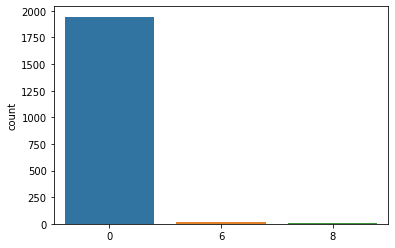

In [41]:
label_plot(target_labels)

Same as in the case of Region peoposal network we have to do a mini batch sampling.our 2000 prposal mostly contains negative class(ie without object).We need to balance positive and ngetive class.

Total we need 128 proposals and out of that 0.25*128=32 proposals should be positive. If we get less than 32 positive proposals keep as it is. if we got > 32 proposals.sample 32 from it. same for negative proposals

In [42]:


req_pos_proposals = n_sample*pos_ratio
image_pos_proposals = len(pos_index)


margin_pos_proposals = int(min(req_pos_proposals,image_pos_proposals)) 

if image_pos_proposals > req_pos_proposals:
    pos_index = np.random.choice(pos_index, size=req_pos_proposals, replace=False)
    


req_neg_proposals = n_sample - margin_pos_proposals
image_neg_proposals = len(neg_index)

if image_neg_proposals > req_neg_proposals:
    neg_index = np.random.choice(neg_index, size=req_neg_proposals, replace=False)


print(len(pos_index))
print(len(neg_index))

23
233


In [43]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = target_labels[keep_index]

# first 13 are positive and rest are negative
gt_roi_labels[margin_pos_proposals:] = 0  # negative labels --> 0

sample_roi = roi[keep_index]
print(sample_roi.shape)

(256, 4)


## Assigning BBOX coords

In [44]:
bbox_for_sampled_roi = bbox[max_iou_roi_index[keep_index]] # ground truth boxes
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = (bbox_for_sampled_roi[:, 0] + 0.5 * base_height).cpu().numpy()
base_ctr_x = (bbox_for_sampled_roi[:, 1] + 0.5 * base_width).cpu().numpy()


# t_{x} = (x - x_{a})/w_{a}
# t_{y} = (y - y_{a})/h_{a}
# t_{w} = log(w/ w_a)
# t_{h} = log(h/ h_a)

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height.cpu().numpy() / height)
dw = np.log(base_width.cpu().numpy() / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

torch.Size([256, 4])
(256, 4)


<br>




---



---



# **3. Fast RCNN**

So now we have gt_roi_locs and gt_roi_labels for the sampled rois. We now need design the Fast rcnn network and predict the locs and labels, Which we will do in the next section.

## **3.1 ROI Pooling**

Region of interest pooling (also known as RoI pooling) purpose is to perform max pooling on inputs of non-uniform sizes to obtain fixed-size feature maps (e.g. 7×7). This layer takes two inputs

* A fixed-size feature map obtained from a deep convolutional network with several convolutions and max-pooling layers
* An Nx5 matrix of representing a list of regions of interest, where N is the number of RoIs. The first column represents the image index and the remaining four are the co-ordinates of the top left and bottom right corners of the region.

In [45]:
# first we will create index for all roi's

rois = torch.from_numpy(sample_roi).float()
roi_indices = np.zeros((len(rois),1), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()


# concat rois and roi_indices, so that we get the tensor with shape [N, 5] (index, x, y, h, w)
indices_and_rois = torch.cat([roi_indices, rois], dim=1)
print(indices_and_rois.shape)

torch.Size([256, 5])


In [46]:
# ROI Layer
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size)

# adjusting roi coordinates
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)
rois = rois.long()
num_rois = rois.size(0)
print(num_rois)
rois

256


tensor([[ 0, 19, 25, 31, 48],
        [ 0, 19, 25, 35, 41],
        [ 0, 16, 25, 32, 41],
        ...,
        [ 0, 22, 43, 30, 50],
        [ 0, 28, 20, 36, 28],
        [ 0, 25,  8, 41, 24]])

In [0]:
output = []
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map[..., roi[1]:roi[3]+1, roi[2]:roi[4]+1]
    output.append(adaptive_max_pool(im))

In [48]:
output = torch.cat(output, 0)
print(output.size())

# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([256, 512, 7, 7])
torch.Size([256, 25088])


## **3.2 Classification and regression heads**

Now this will be the input to a classifier layer, which will further brach out to a classification head and regression head

In [0]:
# defining network
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096),
                                      nn.Linear(4096, 4096)])
cls_loc = nn.Linear(4096, 21 * 4) # (VOC 20 classes + 1 background. Each will have 4 co-ordinates)cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()
score = nn.Linear(4096, 21) # (VOC 20 classes + 1 background)

In [50]:
# passing output of roi pooling through the network

ot = roi_head_classifier(k)
roi_cls_loc = cls_loc(ot)
roi_cls_score = score(ot)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([256, 84]) torch.Size([256, 21])


<br>



---



---







<br>

#**4. Losses**

We have 2 types of network which has further classification loss as well as regression loss

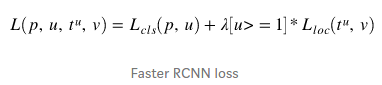

#**4.1 RPN Loss**

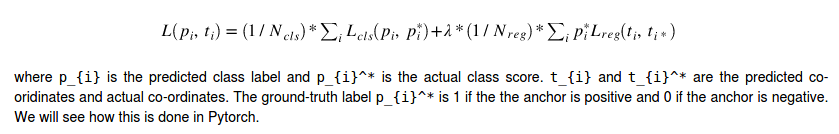

In [51]:
# predicted anchor labels and locations

print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)

rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]


# actual achor labels and locations
print(anchor_locations.shape)
print(labels.shape)

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(labels)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [52]:
# F.cross_entropy already average the loss for each batch
rpn_cls_loss = nn.functional.cross_entropy(rpn_score, gt_rpn_score.long(), ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6933, grad_fn=<NllLossBackward>)


They used L1 loss instead of L2 loss because the values of predicted regression head of RPN are not bounded. Regression loss is also applied to the bounding boxes which have positive label

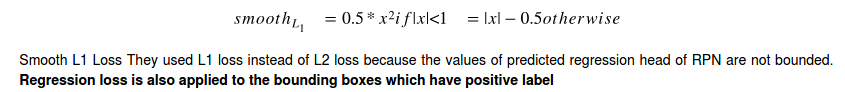

In [53]:
# take only those boxes where objects are present neglet those bg class
mask = gt_rpn_score > 0
print(mask.shape)


# taking only boxes with positive labels
mask_loc_preds = rpn_loc[mask]
mask_loc_targets = gt_rpn_loc[mask]
print(mask_loc_preds.shape, mask_loc_preds.shape)

torch.Size([22500])
torch.Size([18, 4]) torch.Size([18, 4])


In [54]:
x = torch.abs(mask_loc_targets-mask_loc_preds)

rpn_loc_loss = (x<1).float() * 0.5 * x**2 + (x>1).float()*(x-0.5)
print(rpn_loc_loss.sum())

tensor(1.1874, grad_fn=<SumBackward0>)


Combining both

In [55]:
rpn_lambda = 10
N_reg = (gt_rpn_score>0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum()/N_reg
rpn_loss = rpn_cls_loss + rpn_lambda*rpn_loc_loss

print(rpn_loss)

tensor(1.3529, grad_fn=<AddBackward0>)


# **4.2 Fast RCNN Loss**

In [56]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
gt_roi_loc = torch.from_numpy(gt_roi_locs).float()
gt_roi_label = torch.from_numpy(gt_roi_labels).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

torch.Size([256, 84])
torch.Size([256, 21])
torch.Size([256, 4]) torch.Size([256])


classification loss

In [57]:
# classification loss
roi_cls_loss = nn.functional.cross_entropy(roi_cls_score, gt_roi_label, ignore_index=-1)
print(roi_cls_loss)

tensor(3.0412, grad_fn=<NllLossBackward>)


In [58]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)


# we will filter out bounding boxes of the classes we need
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([256, 21, 4])
torch.Size([256, 4])


In [59]:
# we neglet background class
mask = gt_roi_label>0
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)

print(mask_loc_preds.shape, mask_loc_targets.shape)

torch.Size([23, 4]) torch.Size([23, 4])


smooth L1 loss

In [60]:
x = torch.abs(mask_loc_preds - mask_loc_targets)
roi_loc_loss = (x<1).float()*0.5*x**2 + (x>=1).float()*(x-0.5)
roi_loc_loss = roi_loc_loss
print(roi_loc_loss.sum())

tensor(2.1135, grad_fn=<SumBackward0>)


combining both

In [61]:
roi_lambda = 10.
N_reg = (gt_roi_label>0).float().sum()
roi_loc_loss = roi_loc_loss.sum() / N_reg
roi_loss = roi_cls_loss + roi_lambda * roi_loc_loss
print(roi_loss)

tensor(3.9602, grad_fn=<AddBackward0>)


## Total Loss

In [62]:
total_loss = rpn_loss + roi_loss
total_loss

tensor(5.3131, grad_fn=<AddBackward0>)